# Analyzing sat scores

This proyect is about analyzing sat scores and how they correlate to other factors like the size of the school, ethnicity or percentage of native english speakers

## Preliminaries

In [5]:
!ls data

ap_2010.csv	demographics.csv  hs_directory.csv  survey_all.txt
class_size.csv	graduation.csv	  sat_results.csv   survey_d75.txt


In [8]:
# Reading the data files and importing necessary libraries.
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("data/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [14]:
# Reading text files 

all_survey = pd.read_csv("data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey


/home/dum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [17]:
# Creating the DBN columns for the class_size data set and lowercasing the name on the hs_directory

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [18]:
# Converting values stored as text to number

cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


In [19]:
# Extracting longitude and latitude and converting the data to numbers

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [20]:
# Selecting only nine graders from 2012 generations

class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [21]:
# Converting text values to numeric

cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [22]:
# Merging the datasets

combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [23]:
# Generating the district column on the combined dataset
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [26]:
# Printin existing coorelations with the sat_score

correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.sort_values())

frl_percent                            -0.722225
sped_percent                           -0.448170
ell_percent                            -0.398750
hispanic_per                           -0.396985
black_per                              -0.284139
ell_num                                -0.153778
lon                                    -0.132222
lat                                    -0.121029
com_p_11                               -0.115073
male_per                               -0.112062
zip                                    -0.063977
rr_t                                   -0.023386
eng_p_11                                0.020254
hispanic_num                            0.025744
black_num                               0.027979
sped_num                                0.034933
aca_p_11                                0.035155
eng_t_11                                0.036906
CSD                                     0.042948
rr_p                                    0.047925
com_tot_11          

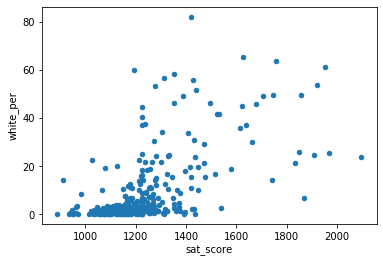

In [31]:
# Plotting correlations

combined.plot.scatter(x = 'sat_score', y = 'white_per')